IMPORTS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score
from scipy.stats import randint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

: 

# Importando os conjuntos da base de dados

In [2]:
test_path = "../test_normalized.csv"
val_path = "../val_normalized.csv"
subtrain_path = "../train_normalized.csv"

df_val = pd.read_csv(val_path, index_col=None)
df_test = pd.read_csv(test_path, index_col=None)
df_subtrain = pd.read_csv(subtrain_path, index_col=None)

In [3]:
print("Validação:", df_val.shape)
print("Teste:", df_test.shape)
print("Sub-conjunto de treinamento", df_subtrain.shape)

Validação: (7200, 23)
Teste: (9000, 23)
Sub-conjunto de treinamento (28800, 23)


In [5]:
X_train_subset = df_subtrain.drop(columns=["loan_status"])
y_train_subset  = df_subtrain["loan_status"]

X_val = df_val.drop(columns=["loan_status"])
y_val = df_val["loan_status"]

X_test = df_test.drop(columns=["loan_status"])
y_test = df_test["loan_status"]

# Unificando os conjuntos de subtreino e validação
X_train = pd.concat([X_train_subset, X_val], axis=0)
y_train= pd.concat([y_train_subset, y_val], axis=0)

# Achando os melhores hiperparâmetros

In [6]:
modelo_dt = DecisionTreeClassifier(random_state=42)

# Hiperparâmetros que serão ajustados
param_dist = {
    'max_depth': randint(1, 21),  
    'min_samples_split': randint(2, 21),  
    'min_samples_leaf': randint(1, 21), 
    'criterion': ['gini', 'entropy'], 
}

melhores_modelos = []
historico_mean_scores = []  
historico_std_scores = []

# Executar o RandomizedSearchCV 20 vezes
for i in range(20):  
    print(f"Executando RandomizedSearchCV {i+1}/20...")

    random_search = RandomizedSearchCV(
        modelo_dt, 
        param_distributions=param_dist, 
        n_iter=1,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),  
        n_jobs=-1,  
        random_state=i,
        scoring='accuracy',
        return_train_score=True
    )

    random_search.fit(X_train_subset, y_train_subset)

    # Média e desvio-padrão das 5 folds na validação cruzada
    mean_scores = random_search.cv_results_['mean_test_score'] 
    std_scores = random_search.cv_results_['std_test_score']

    # Armazena a média e desvio padrão das iterações
    historico_mean_scores.append(np.mean(mean_scores))
    historico_std_scores.append(np.mean(std_scores))
    
    # Dentre os 5 folds, qual teve a melhor média?
    melhores_modelos.append(random_search.best_estimator_)

# Agora, escolher o modelo com a melhor média das pontuações de validação cruzada
indice_melhor = np.argmax(historico_mean_scores)
melhor_modelo_final = melhores_modelos[indice_melhor]

# Exibir os melhores parâmetros do modelo com a melhor média
melhores_parametros = melhor_modelo_final.get_params()

print(f"\nMelhor média de acurácia nos folds: {historico_mean_scores[indice_melhor]:.4f}")
print(f"Melhores parâmetros encontrados: {melhores_parametros}")

Executando RandomizedSearchCV 1/20...
Executando RandomizedSearchCV 2/20...
Executando RandomizedSearchCV 3/20...
Executando RandomizedSearchCV 4/20...
Executando RandomizedSearchCV 5/20...
Executando RandomizedSearchCV 6/20...
Executando RandomizedSearchCV 7/20...
Executando RandomizedSearchCV 8/20...
Executando RandomizedSearchCV 9/20...
Executando RandomizedSearchCV 10/20...
Executando RandomizedSearchCV 11/20...
Executando RandomizedSearchCV 12/20...
Executando RandomizedSearchCV 13/20...
Executando RandomizedSearchCV 14/20...
Executando RandomizedSearchCV 15/20...
Executando RandomizedSearchCV 16/20...
Executando RandomizedSearchCV 17/20...
Executando RandomizedSearchCV 18/20...
Executando RandomizedSearchCV 19/20...
Executando RandomizedSearchCV 20/20...

Melhor acurácia no conjunto de validação: 0.9163
Melhores parâmetros encontrados: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 10}


Plot e resultados da busca de hiperparâmetros

In [1]:
plt.figure(figsize=(12, 6))

plt.errorbar(
    range(1, len(historico_mean_scores) + 1), 
    historico_mean_scores, 
    yerr=historico_std_scores, 
    fmt='o-',  
    color='b', 
    ecolor='r',  
    elinewidth=2, 
    capsize=4, 
    label='Média da Validação Cruzada (com desvio padrão)'
)

plt.xlabel('Execução do RandomizedSearchCV')
plt.ylabel('Pontuação')
plt.title('Média da Validação Cruzada ao Longo das Execuções')
plt.xticks(range(1, len(historico_mean_scores) + 1, max(1, len(historico_mean_scores) // 10)))
plt.grid(True)
plt.legend()
plt.show()

NameError: name 'plt' is not defined

# Treinando e testando o modelo

In [11]:
# Avaliação no conjunto de treinamento
y_train_pred = melhor_modelo_final.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='macro')
recall_train = recall_score(y_train, y_train_pred, average='macro')
f1_train = f1_score(y_train, y_train_pred, average='macro')

# Avaliação no conjunto de teste
y_test_pred = melhor_modelo_final.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, average='macro')
recall_test = recall_score(y_test, y_test_pred, average='macro')
f1_test = f1_score(y_test, y_test_pred, average='macro')

# Exibir os resultados
print("Métricas no Treino:")
print(f"Acurácia: {accuracy_train:.4f}")
print(f"Precisão: {precision_train:.4f}")
print(f"Recall: {recall_train:.4f}")
print(f"F1-Score: {f1_train:.4f}\n")

print("Métricas no Teste:")
print(f"Acurácia: {accuracy_test:.4f}")
print(f"Precisão: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1-Score: {f1_test:.4f}\n")


Métricas no Treino:
Acurácia: 0.9372
Precisão: 0.9322
Recall: 0.8817
F1-Score: 0.9037

Métricas no Teste:
Acurácia: 0.9159
Precisão: 0.8986
Recall: 0.8493
F1-Score: 0.8706



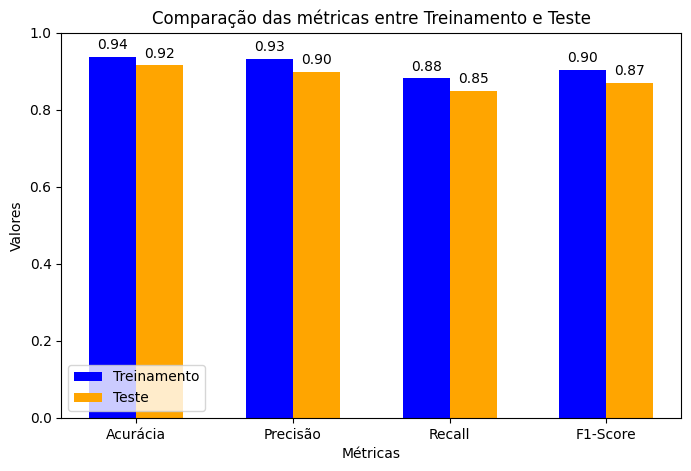

In [12]:
metricas = ["Acurácia", "Precisão", "Recall", "F1-Score"]

# Valores das métricas para treino e teste
valores_treino = [accuracy_train, precision_train, recall_train, f1_train]
valores_teste = [accuracy_test, precision_test, recall_test, f1_test]

# Configuração do gráfico
x = np.arange(len(metricas))  # Posição das barras
largura = 0.3  # Largura das barras

plt.figure(figsize=(8, 5))
plt.bar(x - largura/2, valores_treino, largura, label="Treinamento", color="blue")
plt.bar(x + largura/2, valores_teste, largura, label="Teste", color="orange")

# Adicionando rótulos
plt.xlabel("Métricas")
plt.ylabel("Valores")
plt.title("Comparação das métricas entre Treinamento e Teste")
plt.xticks(x, metricas)  # Define os nomes das métricas no eixo X
plt.legend()
plt.ylim(0, 1)  # Limita o eixo Y de 0 a 1

# Exibir os valores nas barras
for i in range(len(metricas)):
    plt.text(i - largura/2, valores_treino[i] + 0.02, f"{valores_treino[i]:.2f}", ha='center', fontsize=10)
    plt.text(i + largura/2, valores_teste[i] + 0.02, f"{valores_teste[i]:.2f}", ha='center', fontsize=10)

plt.show()

Matriz de confusão


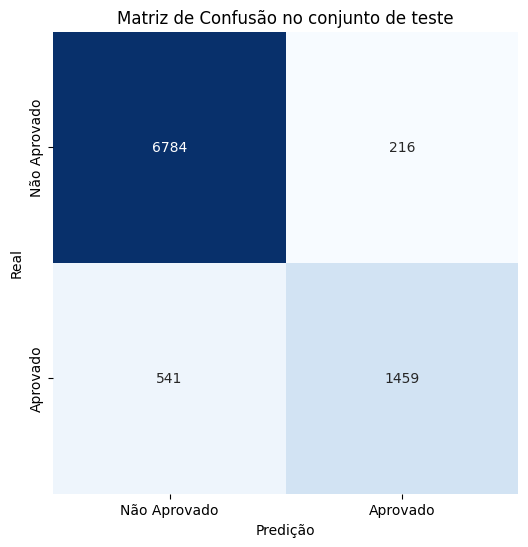

In [14]:
conf_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Não Aprovado', 'Aprovado'], yticklabels=['Não Aprovado', 'Aprovado'])
plt.xlabel('Predição')
plt.ylabel('Real')
plt.title('Matriz de Confusão no conjunto de teste')
plt.show()